## Using Machine Learning To Forecast Energy Consumption

### Importing necessary lbraries

In [77]:
#!pip install xgboost

In [78]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
col_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import xgboost as xgb
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [79]:
data = pd.read_csv('E:\Time Series Analysis\PJME_hourly.csv')
data = data.set_index('Datetime')

data.index = pd.to_datetime(data.index)

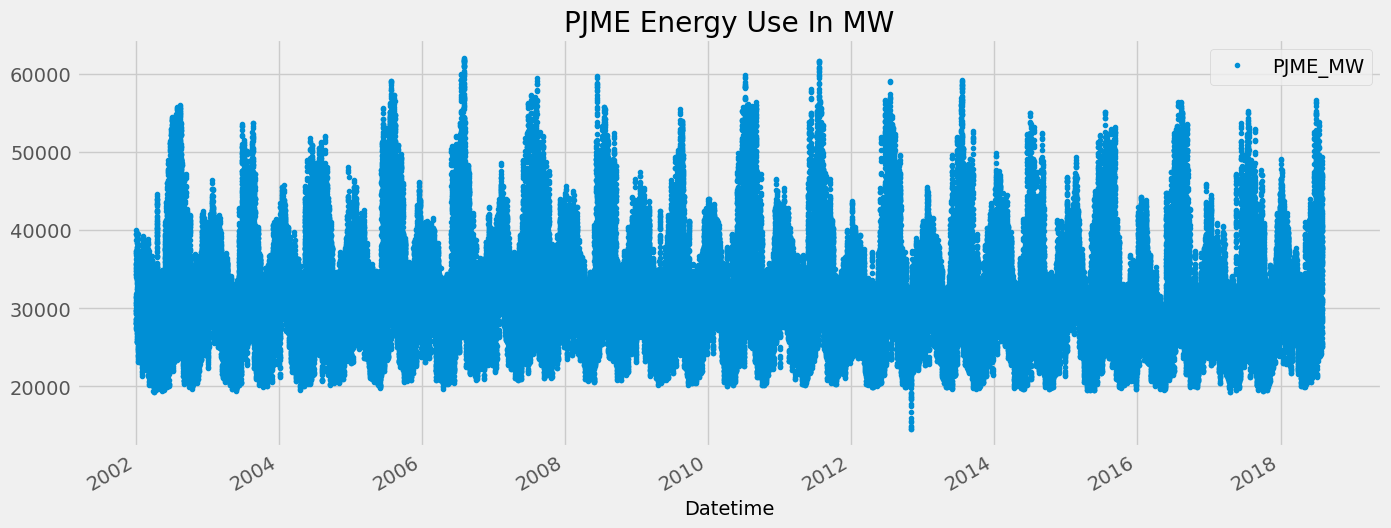

In [80]:
data.plot(style = '.',
          figsize = (15,6),
          color = col_pal[0],
          title = 'PJME Energy Use In MW')

plt.show()

### Train/Test Split

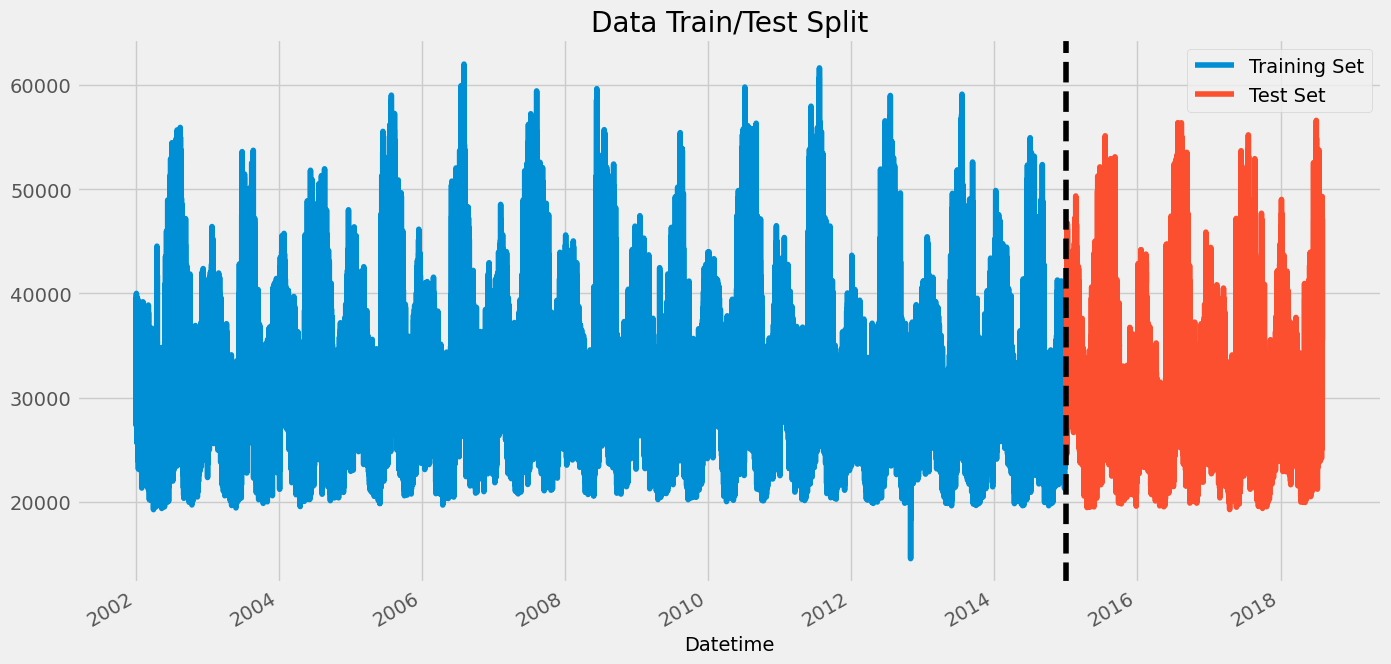

In [81]:
train = data.loc[data.index < '01-01-2015']
test = data.loc[data.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 8))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(pd.Timestamp('2015-01-01'), color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

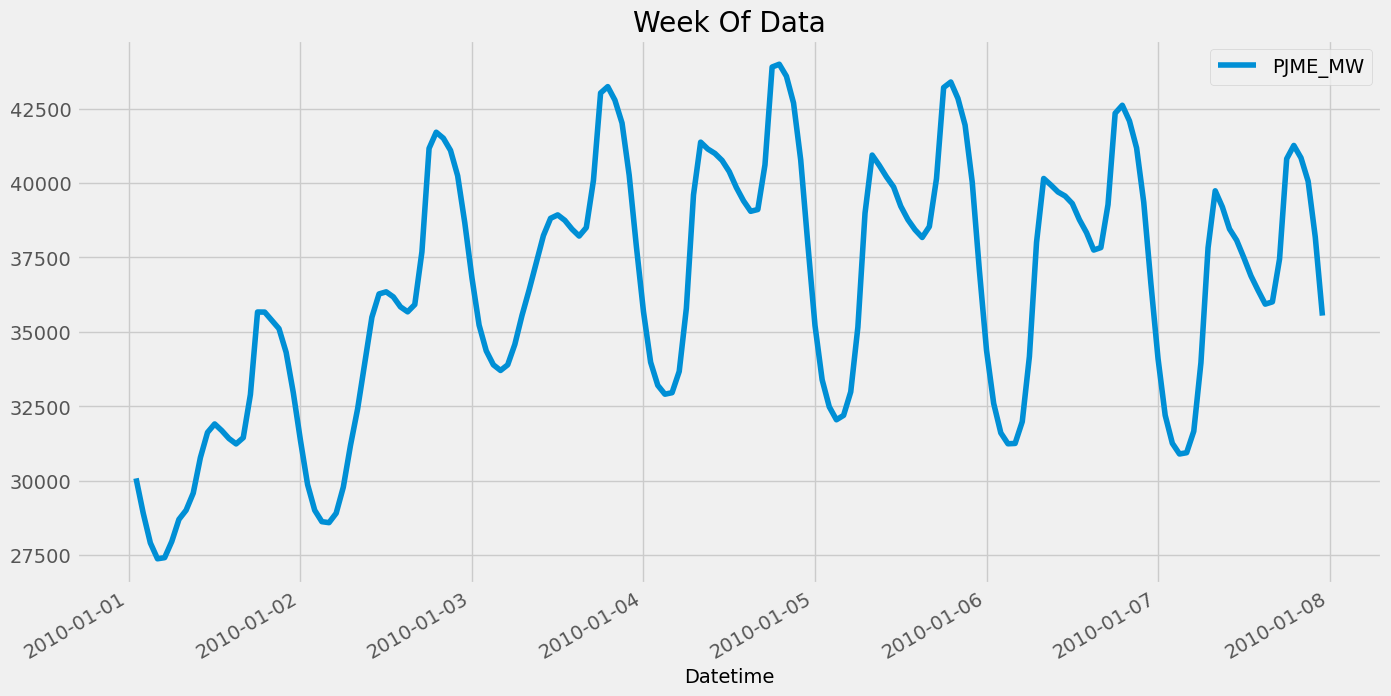

In [82]:
data.loc[(data.index > '01-01-2010') & (data.index < '01-08-2010')] \
    .plot(figsize=(15,8), title='Week Of Data')
    
plt.show()

## Feature Engineering

In [83]:
def create_features(data):
    """
    Create time series features based on time series index.
    """
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofyear'] = data.index.dayofyear
    data['dayofmonth'] = data.index.day
    data['weekofyear'] = data.index.isocalendar().week
    
    return data

data = create_features(data)

## Visualizing Our feature targets

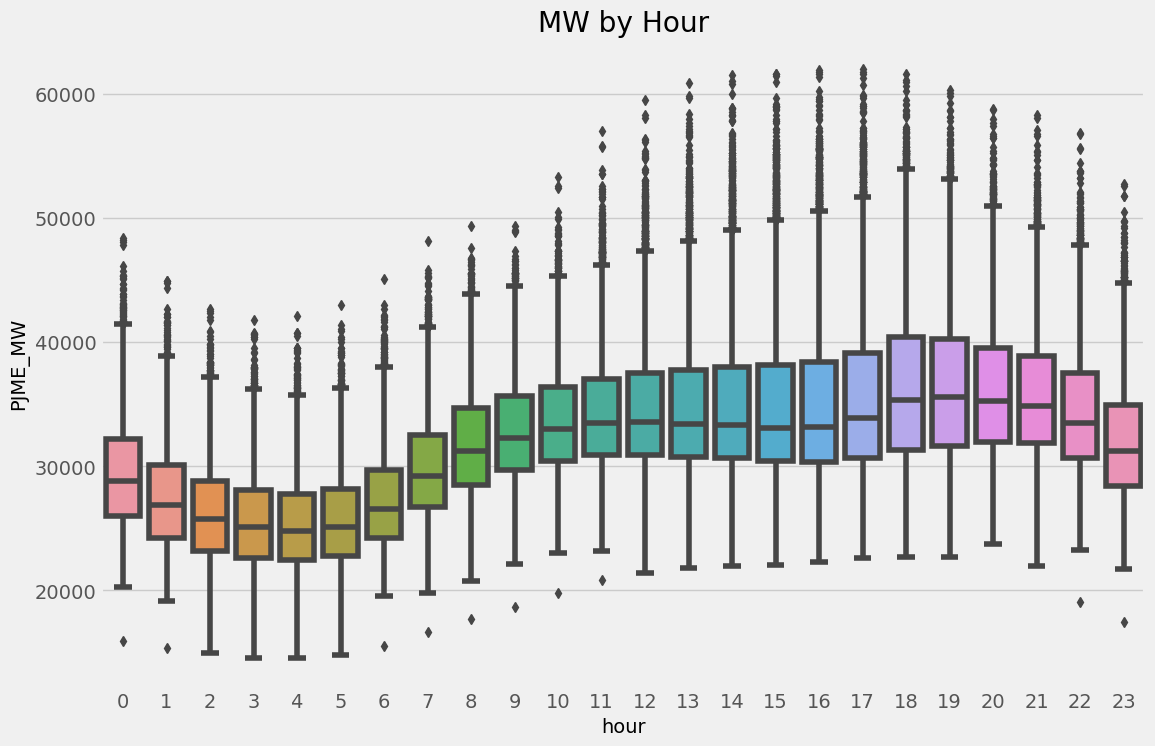

In [84]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=data, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

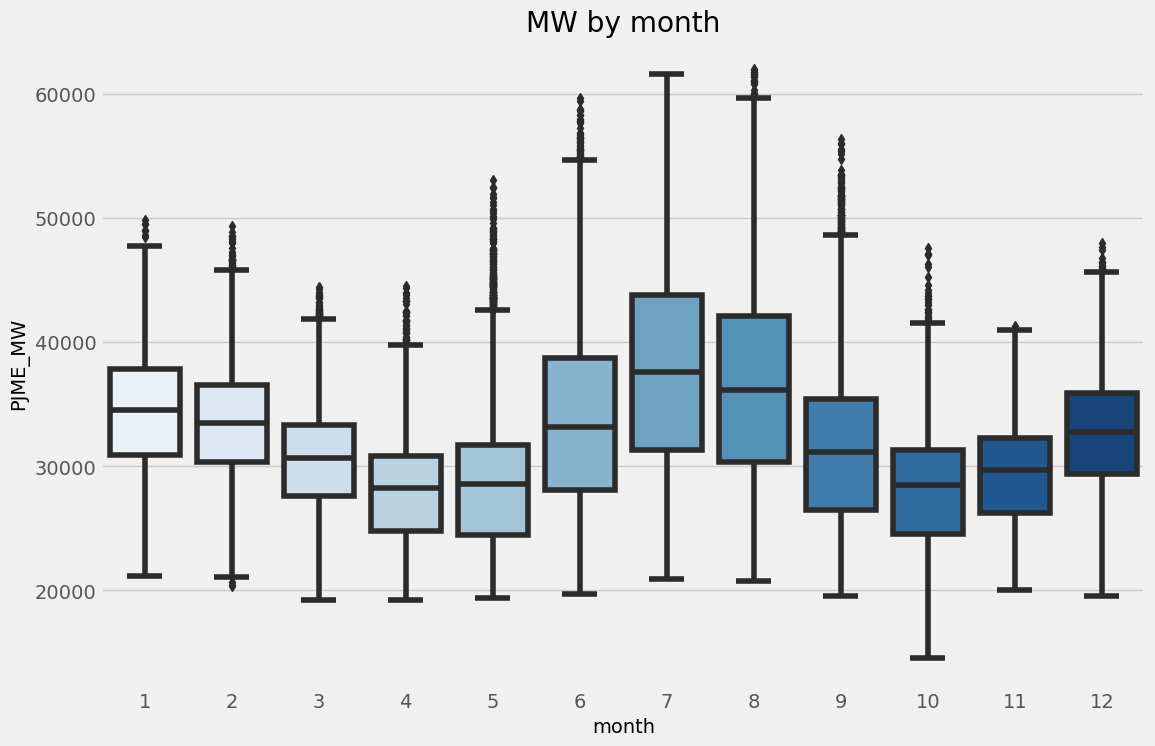

In [85]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=data, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by month')
plt.show()

## Create Our Model

In [86]:
train = create_features(train)
test = create_features(test)

features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
target = 'PJME_MW'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [87]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)],
                                        verbose = 100)

[03:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907


[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Feature Importance

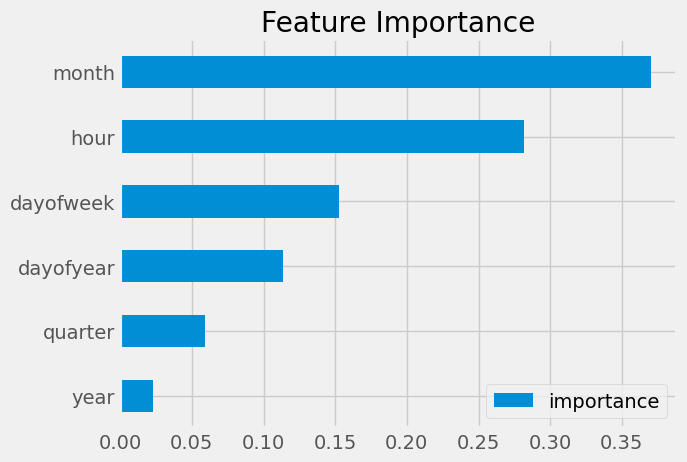

In [88]:
f1 = pd.DataFrame(data = reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance'])

f1.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast On Test

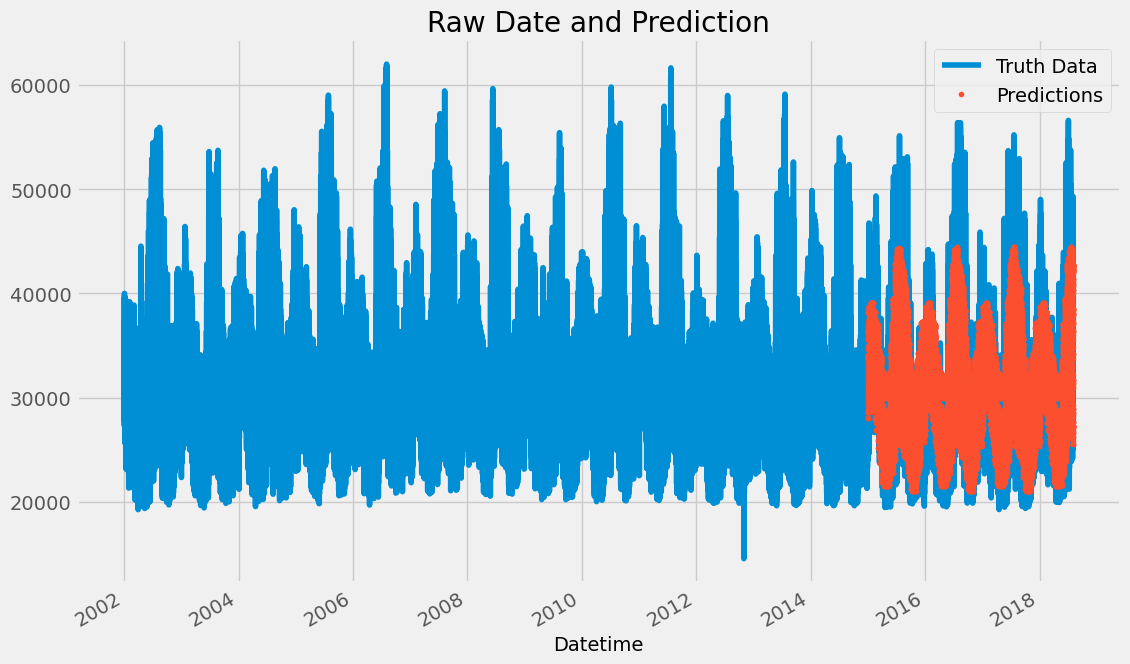

In [89]:
test['prediction'] = reg.predict(X_test)

data = data.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = data[['PJME_MW']].plot(figsize=(12,8))

data['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])

ax.set_title('Raw Date and Prediction')
plt.show()

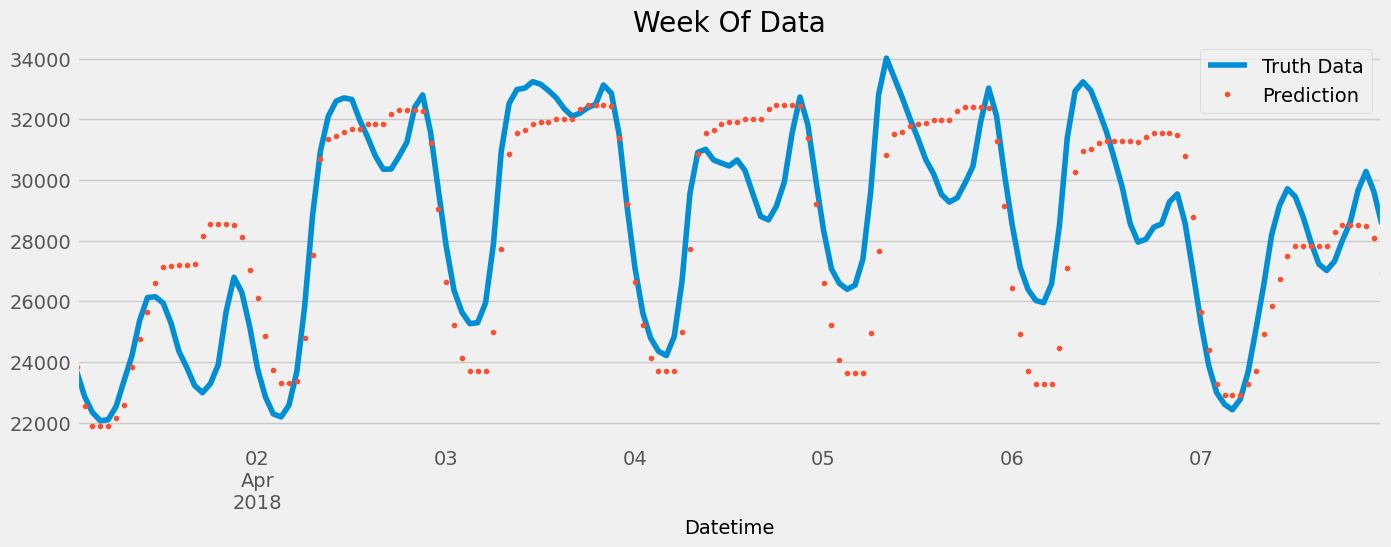

In [90]:
ax = data.loc[(data.index > '04-01-2018') & (data.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
data.loc[(data.index > '04-01-2018') & (data.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Score (RMSE)

In [91]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

print(f'RMSE Score on Test Set: {score:0.2f}')

RMSE Score on Test Set: 3721.75


## Calculation Error

* Look at the worst and best predicted days

In [92]:
test['error'] = np.abs(test[target] - test['prediction'])

test['date'] = test.index.date

test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12839.597087
2016-08-14    12780.209961
2016-09-10    11356.302979
2015-02-20    10965.982259
2016-09-09    10864.954834
2018-01-06    10506.845622
2016-08-12    10124.051595
2015-02-21     9881.803711
2015-02-16     9781.552246
2018-01-07     9739.144206
Name: error, dtype: float64